### Hierarchical Agglomerative Clustering Algorithm Implementation 

In [1]:
import pandas as pd
import numpy as np
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
def Open_file(file_name):
    df = pd.read_csv(file_name, header=None,sep='\t' )
    new_df = df.drop(axis = 1, columns = [0,1])

    col_header = [str(i) for i in range(len(new_df.columns))]
    new_df.columns = col_header
    return [df, new_df]
    

In [3]:
# Forming the clusters
def hac(new_df, number_clusters):
    
    df_array = new_df.to_numpy()
    df_array_dst = squareform(pdist(df_array, 'euclidean'))
    cluster_dct = {i : {i} for i in range(len(df_array_dst))}
    # Set Inf to diagonal elements in a matrix
    for i in range(len(df_array_dst)):
        df_array_dst[i,i] = float('inf')
        
    while True:
        if len(cluster_dct.keys())==number_clusters:
            break
        obj1,obj2 = np.unravel_index(np.argmin(df_array_dst, axis=None), df_array_dst.shape)

        df_array_dst[obj1,:] = np.minimum(df_array_dst[obj1,:], df_array_dst[obj2,:])
        df_array_dst[:,obj1] = np.minimum(df_array_dst[:,obj1], df_array_dst[:,obj2])
        df_array_dst[obj2,:] = df_array_dst[:,obj2] = df_array_dst[obj1,obj2] = df_array_dst[obj1,obj1]= float('inf')

        cluster_dct[obj1] = cluster_dct[obj1]|cluster_dct[obj2]
        cluster_dct.pop(obj2)
        print(cluster_dct)
    return cluster_dct

In [4]:
def cluster_allotment_metrics(cluster_dct, df):
    i=1
    for key in cluster_dct.keys():
        for val in cluster_dct[key]:
            df.loc[val,'cluster_gen'] = int(i)
        i+=1

    ground_cluster = df.iloc[:,1]
    cluster_gen = df.iloc[:,-1]
    return jac_rand(ground_cluster, cluster_gen)

In [5]:
# Clustering Validation
def jac_rand(ground_cluster, cluster_gen):

    cluster1, cluster2 = ground_cluster, cluster_gen
    m_1_1=0
    m_0_0=0
    m_0_1=0
    m_1_0=0

    inc_m_g = np.empty([len(ground_cluster),len(ground_cluster)])
    inc_m_c = np.empty([len(ground_cluster),len(ground_cluster)])

    for i in range(len(ground_cluster)):
        for j in range(len(ground_cluster)):
            inc_m_g[i,j] = 1 if cluster1[i]==cluster1[j] else 0
            inc_m_c[i,j] = 1 if cluster2[i]==cluster2[j] else 0
            if inc_m_g[i,j]==1 and inc_m_c[i,j]==1:
                m_1_1+=1
            elif inc_m_g[i,j]==0 and inc_m_c[i,j]==0:
                m_0_0+=1
            elif inc_m_g[i,j]==1 and inc_m_c[i,j]==0:
                m_1_0+=1
            else:
                m_0_1+=1
    jaccard = m_1_1/(m_1_1 + m_0_1 + m_1_0)
    rand = (m_1_1 + m_0_0)/(m_1_1 + m_0_1 + m_1_0 + m_0_0)
    return [jaccard, rand]

In [6]:
def pca_inbuilt(file):

    file = file.iloc[:,1:]
    file.rename(columns = {1:'Ground_Truth'}, inplace = True)
    
    target = file["cluster_gen"]
    inputs_copy = file.drop(['cluster_gen', 'Ground_Truth'], axis='columns')
    pca = PCA(n_components=2)
    pca_dim = pca.fit_transform(inputs_copy.to_numpy())
    pca_df = pd.DataFrame(pca_dim)
    pca_df.rename(columns = {0:'PCA_1',1:'PCA_2'}, inplace = True)
    pca_df["Target"] = target
    labels = set(pca_df['Target'])
    plt.figure(figsize = (12,12))
    for label in labels:
        index = pca_df['Target'] == label
        plt.plot(pca_df['PCA_1'][index], pca_df['PCA_2'][index],linestyle='none', marker='o', label=label)
        plt.xlabel('PCA_1', fontsize=18)
        plt.ylabel('PCA_2', fontsize=18)
    plt.legend(numpoints=1, fontsize=18)
    plt.title("PCA", fontsize=18)
    plt.show()

**Run the below cell and give the necessary inputs.**

Enter the File name :new_dataset_2.txt
Enter the number of clusters :3
{0: {0, 1}, 2: {2}, 3: {3}, 4: {4}, 5: {5}}
{0: {0, 1, 2}, 3: {3}, 4: {4}, 5: {5}}
{0: {0, 1, 2}, 3: {3}, 4: {4, 5}}
Jaccard :  0.7777777777777778
Rand :  0.8888888888888888


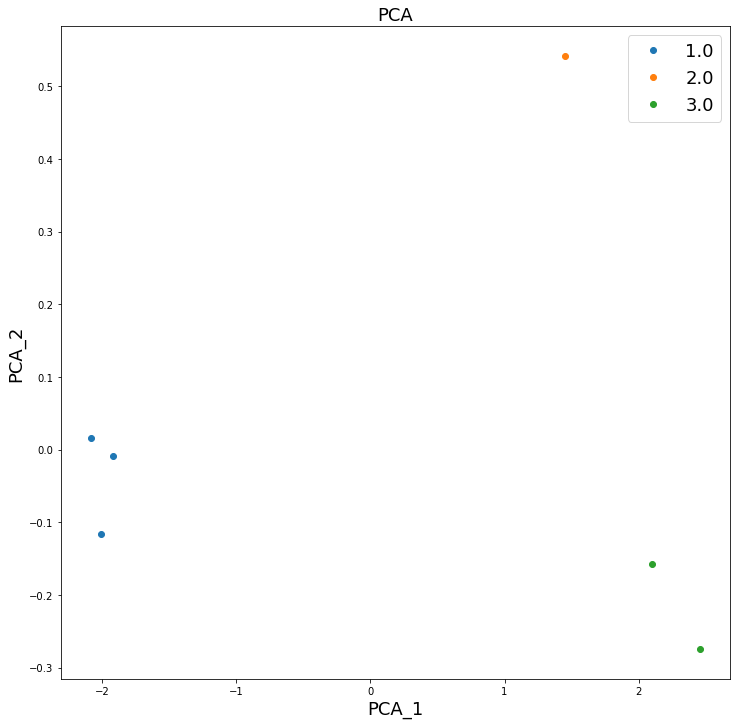

In [9]:
# Reading a dataset and removing the first 2 columns from the dataset

file_name = input("Enter the File name :")
number_clusters = int(input("Enter the number of clusters :"))

df, new_df = Open_file(file_name)   
cluster_dct = hac(new_df, number_clusters)
jaccard,rand = cluster_allotment_metrics(cluster_dct, df)

print("Jaccard : ", jaccard)
print("Rand : ", rand)


pca_inbuilt(df)